<h1><center>NLP</center></h1>

<h3>Elèves:</h3>
<h3><font color="blue">Issame Sarroukh</font></h3>
<h3><font color="blue">Ouassim Sebbar</font></h3>

In [ ]:
# installer les bibiliothèques nécessaires 
!pip install -r requirements.txt

In [1]:
# importation de quelques bibliothèques 
# pandas pour le traitement des données 
import pandas as pd 
# seaborn pour le traçage des graphiques 
import seaborn as sns 
# matplotlib aussi pour le traçage des graphiques 
import matplotlib.pyplot as plt 
# counter permettant de compter les occurrences d'un mot dans une liste de mot, retourne un dictionnaire 
from collections import Counter
# nltk pour le traitement du texte
import nltk
# importation des stopwords
from nltk.corpus import stopwords
# expression regulière pour le traitement du texte 
import re 
# spacy utilisée aussi pour le traitement de texte 
import spacy 

la code utilise une machine Google Cloud EC2 8 coeurs et 32Go de la RAM sans GPU

# Part 1 

In [2]:
# cette partie est faite entierement par nous 
# importation des données 
data = pd.read_csv("Combined_News_DJIA.csv", parse_dates=["Date"])

<AxesSubplot:>

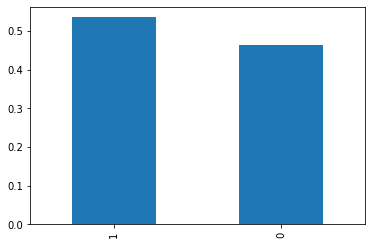

In [3]:
# regarder si les pourcentages par Label 
data["Label"].value_counts(normalize=True).plot.bar()

In [4]:
# pourcentage dans une table 
data["Label"].value_counts(normalize=True).to_frame().style.format("{:.2%}")

,Label
1,53.54%
0,46.46%


<AxesSubplot:xlabel='value', ylabel='Count'>

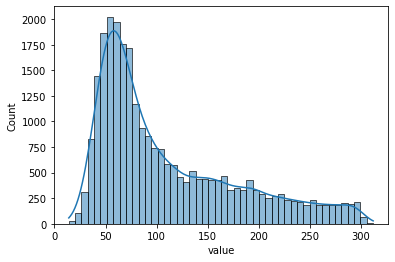

In [5]:
# la distribution des longeurs de mots pour les lignes correspondant à Label = 1 
sns.histplot(pd.melt(data.loc[data["Label"]==1, "Top1":"Top25"])["value"].str.len(), kde=True) 

<AxesSubplot:xlabel='value', ylabel='Count'>

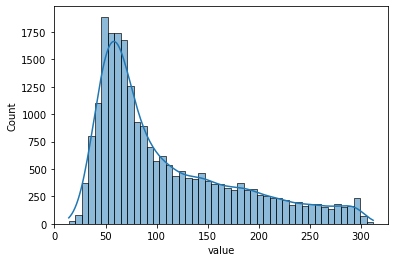

In [6]:
# la distribution des longeurs de mots pour les lignes correspondant à Label = 0
sns.histplot(pd.melt(data.loc[data["Label"]==0, "Top1":"Top25"])["value"].str.len(), kde=True)

aucune différence notable entre les longeurs de text pour Label = 1 et Label = 0

In [3]:
# Elements manquants 
data.isna().sum().where(lambda x: x>0).dropna().to_frame()

,0
Top23,1.0
Top24,3.0
Top25,3.0


In [4]:
# remplir les données manquants par un texte vide
data = data.fillna("") 

In [5]:
# traitement rapide pour regarder selon le label les mots les plus présents dans les actualités
english_words = stopwords.words("english")
def allnews(label=0):
    # faire un melt pour mettre les colonnes dans des lignes, et puis sommer selon les lignes pour obtenir tout 
    # le texte
    newstext = (pd.melt(data.loc[data["Label"]==label, "Top1":"Top25"])["value"]+'\n').sum()
    # texte en minuscule 
    newstext = newstext.lower()
    # detecter les mots avec une lettre et les enlever  
    newstext = re.sub("[^a-z]", " ", newstext) 
    # laisser seulement du texte \b correspond au début d'un mot et à la fin dans mot 
    newstext = re.sub(r"\b[a-z]\b", ' ', newstext)
    # enlever des stopwords avec une expression régulière avec l'opération | qui est où,  on remplace les stop words par 
    # un texte vide 
    newstext = re.sub(r"\b" + r"\b|\b".join(english_words) + r"\b", "", newstext) 
    return newstext

In [10]:
# utilisation de la bibliothèque wordcloud pour la visualisation 
from wordcloud import WordCloud,STOPWORDS

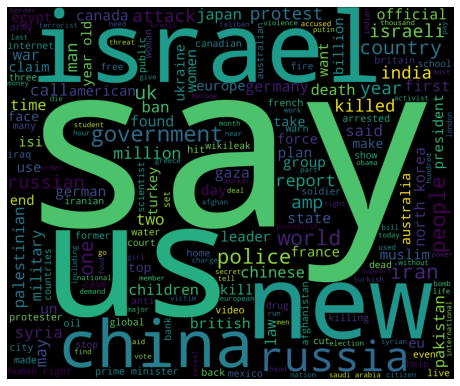

In [11]:
# pour le label 0, les mots les plus présents dans les news 
wordcloud1 = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(allnews())
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

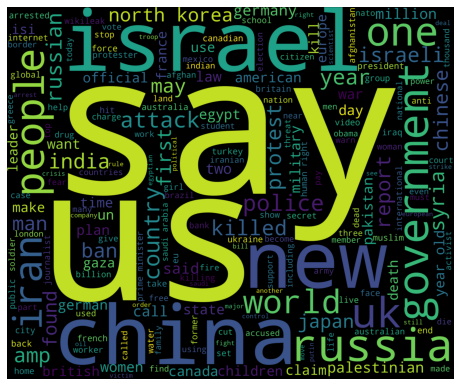

In [12]:
# pour 0 les mots les plus présents dans les news 
wordcloud2 = WordCloud(background_color='black',
                      width=3000,
                      height=2500
                     ).generate(allnews(1))
plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

Il n'y a pas de différence notable entre les mots les plus fréquents dans le cas de Label = 1 et Label = 0, contrairement à des applications comme l'analyse des sentiments, nous remarquons dans le cas où Label = 1 que le mot gouvernement apparaît plus que dans le cas de Label = 0, Le problème avec ce type de prédiction est que les nouvelles ne permettent pas une détection réelle des mouvements quotidiens des actions, parce qu'elles dépendent aussi d'autres paramètres, de plus les nouvelles ne se concentrent pas seulement sur le secteur industriel (Dow Jones), donc, nous ne devrions pas nous attendre à un score assez élevé pour le modèle. 

# Part 2 

In [6]:
# cette partie est entierement réalisé par nous
# ce petit traitement est ajouté pour permettre d'enlever quelques éléments présents dans certains phrases
# par exemple: on trouve des phrases entourer par b' (b'<phrase>' et b"<phrase>")
for i in range(1, 25 + 1):

    data["Top%d"%i] = data["Top%d"%i].str.replace(r"""^b"|^b'""", "", regex=True).str.replace(r'''"$|'$''', "", regex=True)

In [7]:
# on fait une somme des news pour créer une seule variable news par ligne 
columns = ["Top%d"%i for i in range(1, 1 + 25)]
data["news"] = (data.loc[:, "Top1":"Top25"] + ". ").sum(axis=1)
data.drop(columns=columns, inplace=True)

In [8]:
# on utilise le bibliothèque spacy pour le vocabulaire anglais 
nlp = spacy.load('en_core_web_sm')
def text_tokenizer(text): 
    # détecter le mot US et le remplacer par us car rassemble à un autre mot en anglais "us"="nous"
    text = re.sub(r"\bUS\b", "usa", text)
    text = text.lower()
    # replacer u.s. par usa 
    text = text.replace("u.s.", "usa")
    # régler un petit problème de formatage de texte qui fait que certains mots ne sont pas détecter 
    text = text.replace("\\", "")
    # replace - par un espace car on trouve dans le texte des mots comme 5-year 
    text = text.replace("-", " ")
    # remplacer u.n. par un 
    text = text.replace("u.n.", 'un')
    # garder les mots seulements en applicant la lemmatisation et on ne garde pas les stopwords
    # on laisse que du texte 
    text = [word.lemma_ for word in nlp(text)
            if not word.is_stop and word.is_alpha] 
    return text 

In [9]:
# regarder ce que le traitement donne 
for i in range(2):
    print(60*'-')
    print(i, *text_tokenizer(data["news"].iloc[i]), sep='\t')    

------------------------------------------------------------
0	georgia	down	russian	warplane	country	brink	war	breaking	musharraf	impeach	russia	today	column	troop	roll	south	ossetia	footage	fight	youtube	russian	tank	move	capital	south	ossetia	reportedly	completely	destroy	georgian	artillery	fire	afghan	child	rape	impunity	un	official	say	sick	year	old	rape	russian	tank	enter	south	ossetia	whilst	georgia	shoot	russian	jet	breaking	georgia	invade	south	ossetia	russia	warn	intervene	enemy	combatent	trial	sham	salim	haman	sentence	year	keep	long	feel	like	georgian	troop	retreat	osettain	capital	presumably	leave	people	kill	video	usa	prep	georgia	war	russia	rice	give	green	light	israel	attack	iran	say	usa	veto	israeli	military	op	announce	class	action	lawsuit	behalf	american	public	fbi	russia	georgia	war	nyt	story	open	ceremony	olympic	fucking	disgrace	proof	decline	journalism	china	tell	bush	stay	country	affair	world	war	iii	start	today	georgia	invade	south	ossetia	russia	gets	involve	na

In [9]:
# division en train et test selon les consignes 
from datetime import datetime  
train_start = datetime(2008, 8, 8) 
train_end = datetime(2014, 12, 31)
test_start = datetime(2015, 1, 2)
test_end = datetime(2016, 7, 1)
train = data.copy().loc[data["Date"].between(train_start, train_end)]
test = data.copy().loc[data["Date"].between(test_start, test_end)]
print("train:", train["Date"].min(), train["Date"].max())
print("test:", test["Date"].min(), test["Date"].max())  

train: 2008-08-08 00:00:00 2014-12-31 00:00:00
test: 2015-01-02 00:00:00 2016-07-01 00:00:00


In [11]:
# verifier les pourcentages d'entrainement et de test
perc = pd.concat([train.Label.value_counts(normalize=True), test.Label.value_counts(normalize=True)], axis=1)
perc.columns = ["train", 'test'] 
perc.style.format("{:.2%}") 

,train,test
1,54.19%,50.79%
0,45.81%,49.21%


# Part3

In [12]:
# cette partie est faite entierement par nous 
# importation de quelques bibliothèques
# la bibliothèque permettant de compter les mots de sklearn
from sklearn.feature_extraction.text import CountVectorizer
# Word2Vec de gensim
from gensim.models import Word2Vec
# keras de tensorflow 
from tensorflow import keras
# la bibliothèque permettant de fixer la longueur du texte de chaque observation 
from tensorflow.keras.preprocessing.sequence import pad_sequences
# bibliothèque numpy pour les matrices 
import numpy as np 

In [13]:
# utilisation de la classe count vectorizer 
# on garde seulement les mots présents au minimum une fois et au maximum 90% des fois
vectorizer = CountVectorizer(max_df=0.9, ngram_range=(1, 1), min_df=1, tokenizer=text_tokenizer)

In [14]:
# créer un vecteur qui compte le nombre de mots 
# les données sont ajustées sur les données d'entrainemnt 
X_train_vec = vectorizer.fit_transform(train["news"])
# les données test et entrainement sont transformées 
X_test_vec = vectorizer.transform(test["news"])

In [15]:
# Application d'un tokenizer sur les données d'entrainement 
train_text = train["news"].apply(lambda news: text_tokenizer(news)).to_list()
# application du tokenizer sur les données test 
test_text = test["news"].apply(lambda news: text_tokenizer(news)).to_list()

In [16]:
# longueur maximale de chaque actualité 
maxlen = 200
# nombre maximale de mots pour encoder le texte 
max_words = 10000
# la dimension du vecteur représentant un seul mot par approche Word2Vec
embedding_dim = 32

In [17]:
# entrainement du modele word2vec, avec un embedding dim égale à 32, cela peut faire objet d'un validation
# pour choisir la bonne valeur, mais cette partie est indépendente de la suivante, la documentation dit
# d'un ordre de grandeur de 10 voir 100, il s'agit de la dimension du vecteur d'embedding 
# sg=1 correspond à l'approche skip gram moins rapide mais plus performante
model = Word2Vec(sentences=train_text, vector_size=embedding_dim, window=3, min_count=1, workers=-1, sg = 1)

In [18]:
import itertools 
# chain pour grouper les listes en une seule liste 
# dictionnaire (Counter) contient le nombre d'occurances de chaque mot en s'appuyant sur les données d'entrainement 
word_counter = Counter(list(itertools.chain.from_iterable(train_text)))
# transfomer le dictionnaire en liste de tuples 
word_counter = list(word_counter.items())
# sorted pour trier par le nombre d'ocurrances de plus grand au plus petit (reverse = True)
word_counter = sorted(word_counter, key=lambda x: x[1], reverse=True)
# list des mots ordonnés par nombre d'occurences
words = list(map(lambda x: x[0], word_counter))
# associer a chaque mot un ordre 
word_index = dict(zip(words, range(1, len(words)+1)))
# dictionnaire de la transformation inverse 
index_word = dict(zip(range(1, len(words)+1), words))

In [19]:
# faire la transformation en liste de sequences, on s'est basé sur la documentation de tokenizer de keras 
# on garde que les mots d'ordre inférieur à max_words-1 
train_sequences = [[word_index[word] for word in news if word_index.get(word, max_words) <max_words] for news in train_text]
test_sequences = [[word_index[word] for word in news if  word_index.get(word, max_words) <max_words] for news in test_text]
# faire un padding ou enlever des élements pour chaque sequence pour arriver à un nombre fixe de nombre de mots 
# par texte 
train_sequences = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [20]:
# créer la matrice d'embedding, on utilise que les "max_words-1" mots 
embedding_words = words[:max_words-1]
embedding_matrix = np.zeros((max_words, embedding_dim))
# la premiere colonne contient que des zeroes et correspond à l'indice 0 du padding 
# model.vw permet d'acceder au vecteur d'embedding pour un mot apres entrainement du modele word2vec 
embedding_matrix[1:] = np.array([model.wv[word] for word in embedding_words])

# Part 4

In [21]:
# importation de quelques couches du réseaux de neuronnes 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN, Bidirectional, LSTM, Dropout
n = len(train_sequences)
# on utilise les données test dans la validation (dans les applications réels les données de validation
# ne doivent pas être une partie des données test mais des données utilisées seulement pour 
# la choisir le meilleur modèle)
x_train = train_sequences
x_val = test_sequences
y_train = train["Label"]
y_val = test["Label"]

In [55]:
%%time 
# intilialiser le réseau de neurones 
model = Sequential()
# ajout d'un embedding avec des dimensions indentiques aux Word2Vec 
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# on utilise du SimpleRNN car on arrive à un surapprentissage avec des modèles plus complexe comme du LSTM 
# ou Biderctioonal LSTM, aussi le modèle est choisi avec peu de neurones pour la même raison 
# dropout est utilisé aussi pour combattre l'effet de surapprentissage 
model.add(SimpleRNN(2, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
# la matrice d'embedding doit etre remplacer par l'embedding donné par Word2Vec 
model.layers[0].set_weights([embedding_matrix])
# les éléments de la matrice doivent être fixés, Word2Vec est une bonne approche dans le cas ou on a peu de données
# et on veux utiliser un modèle Word2Vec pré-entrainer sur beaucoup de données 
model.layers[0].trainable = False
# on utilise un optimizer adam sans jouer sur le taux associé, avec d'un binary corss entropy 
# y log(p) + (1-y) log(1-p)
# metric est l'accuracy puisqu'on a un peu pres le meme nombre test et entrainement 
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['acc'])
# on choisit un nombre d'epoch egale à 1 et un batch size de 16, pour combattre le surentrainement 
# on joue aussi sur les poids car le modèle à tendence à favoriser les 1 
history = model.fit(x_train, y_train,
epochs=1, 
batch_size=16,
validation_data=(x_val, y_val), class_weight = {0: 100.,
                1: 90.})

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 200, 32)           320000    
_________________________________________________________________
simple_rnn_30 (SimpleRNN)    (None, 2)                 70        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 3         
Total params: 320,073
Trainable params: 320,073
Non-trainable params: 0
_________________________________________________________________
101/101 [==============================] - 5s 40ms/step - loss: 67.1119 - acc: 0.4849 - val_loss: 0.6921 - val_acc: 0.5503
Wall time: 5.29 s


In [59]:
# loader le modèle pré-entrainer 
model = keras.models.load_model("model1") 

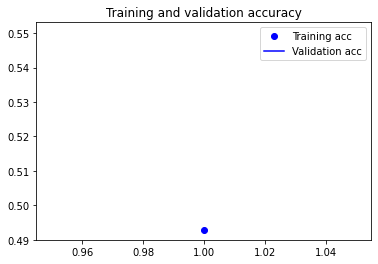

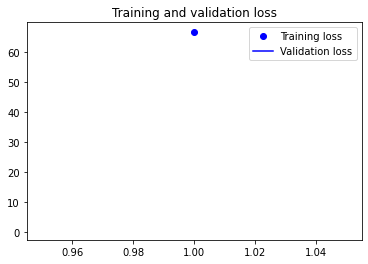

In [60]:
# on trace sur un meme graphique l'accuracy test et entrainement 
# on trace sur le meme graphique loss test et entraineemnt 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Lorsque nous testons avec plusieurs epochs, nous remarquons que le modèle sur-apprend rapidement sur les données d'entraînement et donne des résultats moins satisfaisants sur les données de validation, cela signifie que le problème de la prédiction de la variation des actions à travers les nouvelles est délicat, les actualités n'ont pas toujours un effet sur le mouvement des titres. 

In [61]:
ypred = 1*(model.predict(test_sequences)>0.5)

In [62]:
from sklearn.metrics import classification_report
print(classification_report(test["Label"], ypred))

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       186
           1       0.56      0.52      0.54       192

    accuracy                           0.55       378
   macro avg       0.55      0.55      0.55       378
weighted avg       0.55      0.55      0.55       378



On arrive à un modèle avec 55% d'accuracy, ce qui est assez faible, ces résultats sont assez similaires à ceux de certaines personnes qui ont partagé leur approche sur kaggle, elles arrivent à des résultats aux alentours de 50% pour l'accuracy avec des approches différentes de la nôtre, cela signifie que le modèle a une accuracy proche de celle d'un modèle qui prédit 1 tout le temps (50,79%). 

Le modèle a un bon score F1, supérieur à la moyenne.

In [128]:
# importation des données d'entrainement et de test. 
n = len(train_sequences)
x_train = X_train_vec.toarray()
x_val = X_test_vec.toarray()
y_train = train["Label"]
y_val = test["Label"]

In [191]:
%%time 
# cette représentation ne permet pas l'application des méthodes comme RNN et CNN 1D, car chaque texte est réprésenter
# avec un seul vecteur contenant les occurences des mots les plus fréquents. Les approches RNN et CNN 1D nécessite 
# d'avoir une matrice tridimentionnel avec un ordre dans les vecteurs de chaque observation, ce qui n'est pas le 
# cas dans la représentation Bag of words, on entraine un modèle DNN simple
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
# on initilialise le modèle 
model = Sequential()
# on calcule la dimension des données d'entrainement 
input_dim = X_train_vec.shape[1]
# ajout d'une couche à 4 neurones 
model.add(Dense(4, input_dim=input_dim, activation='relu'))
# toujours du dropout pour éviter le surapprentissage 
model.add(Dropout(0.5))
# sortie une probabilité entre 0 et 1 
model.add(Dense(1, activation='sigmoid'))
# les paramétres sont choisis comme discuté précédément 
model.compile(optimizer="adam",
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=2, 
batch_size=16,
validation_data=(x_val, y_val), class_weight = {0: 100.,
                1: 95.}) 

Epoch 1/2
101/101 [==============================] - 1s 8ms/step - loss: 67.6034 - acc: 0.5040 - val_loss: 0.6925 - val_acc: 0.5079
Epoch 2/2
101/101 [==============================] - 1s 6ms/step - loss: 64.1683 - acc: 0.5692 - val_loss: 0.6910 - val_acc: 0.5185
Wall time: 1.98 s


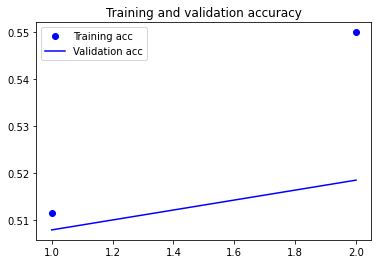

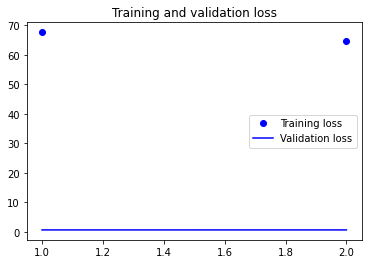

In [192]:
# traçage de l'accuracy et de la fonction loss 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [196]:
# chargement du modèle préentrainer 
model = keras.models.load_model("model2")  

In [197]:
# prédiction 
ypred = 1*(model.predict(x_val)>0.5)

In [198]:
# les résultats obtenus, ils sont similaires à l'approche précédente mais avec une accuracy de 52%
from sklearn.metrics import classification_report
print(classification_report(test["Label"], ypred))

              precision    recall  f1-score   support

           0       0.51      0.65      0.57       186
           1       0.54      0.40      0.46       192

    accuracy                           0.52       378
   macro avg       0.52      0.52      0.51       378
weighted avg       0.52      0.52      0.51       378



# Part 5

In [10]:
# importation de DistilBert, on choisit une longeur de texte de 128 et un batch size de 32 
# un seul epoch car le modèle prend du temps pour être entrainer meme sur la machine Google Cloud 
import tensorflow as tf
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
MAX_LENGTH = 128
BATCH_SIZE = 32
N_EPOCHS =  1

In [11]:
# utilisation du tokenizer préentrainer 
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [12]:
# la tokenization des données d'entrainement 
train_encodings = tokenizer(list(train["news"].values),
                            truncation=True, 
                            padding=True)
# de meme pour les données test 
test_encodings = tokenizer(list(test["news"].values),
                            truncation=True, 
                            padding=True)

In [13]:
# transformation en des datasets de TF 
train_dataset =  tf.data.Dataset.from_tensor_slices((dict(train_encodings),
                                    list(train["Label"].values)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings),
                                    list(test["Label"].values)))

In [14]:
# chargement du modèle préentrainer 
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [15]:
# finetuning avec nos données d'entrainement 
%%time 
model.compile(optimizer= "adam",
loss='binary_crossentropy',
metrics=['acc'])
model.fit(train_dataset.shuffle(len(train)).batch(BATCH_SIZE),
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
51/51 [==============================] - 904s 18s/step - loss: 1.5623 - acc: 0.5253
CPU times: user 1h 26min 15s, sys: 23min 45s, total: 1h 50min
Wall time: 15min 4s


In [16]:
# évaluation sur les données test, le modèle ne prédit que des 1, l'accuracy est de 50,79% 
model.evaluate(test_dataset.shuffle(len(test)).batch(BATCH_SIZE), 
               return_dict=True, 
               batch_size=BATCH_SIZE,
               use_multiprocessing=True, 
              workers=-1)

12/12 [==============================] - 67s 5s/step - loss: 0.6965 - acc: 0.5079


{'loss': 0.696466326713562, 'acc': 0.5079365372657776}